### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

df = pd.read_csv("Mall_Customers.csv")
df.dropna(inplace=True)

### 1. Проверка: «Мужчины и женщины тратят 50% дохода на супермаркеты» 
### H0: μ = 50  (для каждой группы отдельно)

In [2]:
spending_male = df[df["Genre"] == "Male"]["Spending Score (1-100)"]
spending_female = df[df["Genre"] == "Female"]["Spending Score (1-100)"]

alpha = 0.05

# Для мужчин
t_m, p_two_m = stats.ttest_1samp(spending_male, 50)
p_one_m = p_two_m / 2 if t_m > 0 else 1 - p_two_m / 2

# Для женщин
t_f, p_two_f = stats.ttest_1samp(spending_female, 50)
p_one_f = p_two_f / 2 if t_f > 0 else 1 - p_two_f / 2

print(f"Мужчины: t = {t_m:.4f}, p_двусторонний = {p_two_m:.4f}")
print(f"Женщины: t = {t_f:.4f}, p_двусторонний = {p_two_f:.4f}")

# Двусторонний тест, так как проверяем утверждение "ровно 50"
if p_two_m >= alpha:
    print("→ Для мужчин: не отвергаем H0 (μ = 50)")
else:
    print("→ Для мужчин: отвергаем H0")

if p_two_f >= alpha:
    print("→ Для женщин: не отвергаем H0 (μ = 50)")
else:
    print("→ Для женщин: отвергаем H0")


Мужчины: t = -0.5006, p_двусторонний = 0.6179
Женщины: t = 0.6700, p_двусторонний = 0.5042
→ Для мужчин: не отвергаем H0 (μ = 50)
→ Для женщин: не отвергаем H0 (μ = 50)


### 2. Доход мужчин > дохода женщин 
### H0: μ_m ≤ μ_f   vs   H1: μ_m > μ_f

In [3]:
income_male = df[df["Genre"] == "Male"]["Annual Income (k$)"]
income_female = df[df["Genre"] == "Female"]["Annual Income (k$)"]

# Критерий Левена для равенства дисперсий
levene_stat, levene_p = stats.levene(income_male, income_female, center='mean')
equal_var = levene_p >= alpha  # True, если дисперсии равны

print(f"Критерий Левена: p = {levene_p:.4f} → {'равные' if equal_var else 'неравные'} дисперсии")

# t-тест (односторонний)
t_stat, p_two = stats.ttest_ind(income_male, income_female, equal_var=equal_var)
p_one = p_two / 2 if t_stat > 0 else 1 - p_two / 2

print(f"t = {t_stat:.4f}, односторонний p = {p_one:.4f}")

if p_one < alpha:
    print("→ Отвергаем H0: доход мужчин статистически значимо выше")
else:
    print("→ Не отвергаем H0: нет доказательств, что доход мужчин выше")

# Сравнение с statsmodels
d1 = DescrStatsW(income_male)
d2 = DescrStatsW(income_female)
cm = CompareMeans(d1, d2)
t_sm, p_sm, _ = cm.ttest_ind(usevar='pooled' if equal_var else 'unequal')
p_one_sm = p_sm / 2 if t_sm > 0 else 1 - p_sm / 2
print(f"[statsmodels] t = {t_sm:.4f}, односторонний p = {p_one_sm:.4f}")

Критерий Левена: p = 0.9181 → равные дисперсии
t = 0.7950, односторонний p = 0.2138
→ Не отвергаем H0: нет доказательств, что доход мужчин выше
[statsmodels] t = 0.7950, односторонний p = 0.2138


### 3. Равенство дисперсий возраста
### H0: σ²_male = σ²_female

In [4]:
age_male = df[df["Genre"] == "Male"]["Age"]
age_female = df[df["Genre"] == "Female"]["Age"]

# Критерий Левена
levene_stat_age, levene_p_age = stats.levene(age_male, age_female, center='mean')
print(f"Критерий Левена: p = {levene_p_age:.4f}")

if levene_p_age < alpha:
    print("→ Отвергаем H0: дисперсии различаются")
else:
    print("→ Не отвергаем H0: дисперсии можно считать равными")

# F-тест (менее надёжен, но по заданию)
s1_sq = np.var(age_male, ddof=1)
s2_sq = np.var(age_female, ddof=1)
if s1_sq >= s2_sq:
    F = s1_sq / s2_sq
    df1, df2 = len(age_male) - 1, len(age_female) - 1
else:
    F = s2_sq / s1_sq
    df1, df2 = len(age_female) - 1, len(age_male) - 1

p_right = 1 - stats.f.cdf(F, df1, df2)
p_F = 2 * p_right  # двусторонний

print(f"F-тест: F = {F:.4f}, p = {p_F:.4f}")
if p_F < alpha:
    print("→ F-тест: отвергаем H0")
else:
    print("→ F-тест: не отвергаем H0")

Критерий Левена: p = 0.0219
→ Отвергаем H0: дисперсии различаются
F-тест: F = 1.5056, p = 0.0420
→ F-тест: отвергаем H0


## II. Непараметрическая часть: надёжность двигателя


In [5]:
N_blades = 100
lam = 2.0
n_engines = 5000

# Генерация выборки
ti = np.random.exponential(scale=1/lam, size=(n_engines, N_blades))
T = ti.sum(axis=1)

print(f"Выборочное среднее T: {np.mean(T):.3f}")
print(f"Теоретическое среднее: {N_blades / lam:.1f}")

print(f"Выборочная дисперсия T: {np.var(T, ddof=1):.3f}")
print(f"Теоретическая дисперсия: {N_blades / lam**2:.1f}")

Выборочное среднее T: 50.036
Теоретическое среднее: 50.0
Выборочная дисперсия T: 25.680
Теоретическая дисперсия: 25.0


### Оценка параметров гамма-распределения

In [6]:
mean_T = np.mean(T)
var_T = np.var(T, ddof=1)
k_hat = mean_T**2 / var_T
theta_hat = var_T / mean_T

print(f"\nОценка k (shape): {k_hat:.2f} vs теоретическое: {N_blades}")
print(f"Оценка θ (scale): {theta_hat:.4f} vs теоретическое: {1/lam}")


Оценка k (shape): 97.49 vs теоретическое: 100
Оценка θ (scale): 0.5132 vs теоретическое: 0.5


### Гистограмма

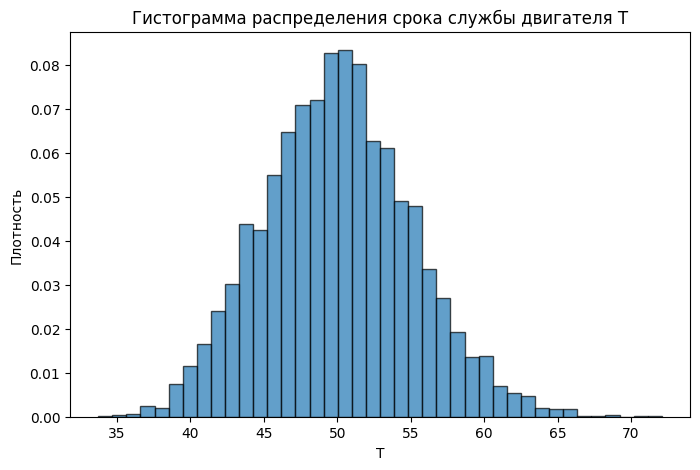

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(T, bins=40, density=True, edgecolor='black', alpha=0.7)
plt.title("Гистограмма распределения срока службы двигателя T")
plt.xlabel("T")
plt.ylabel("Плотность")
plt.show()

### Эмпирическая и теоретическая CDF

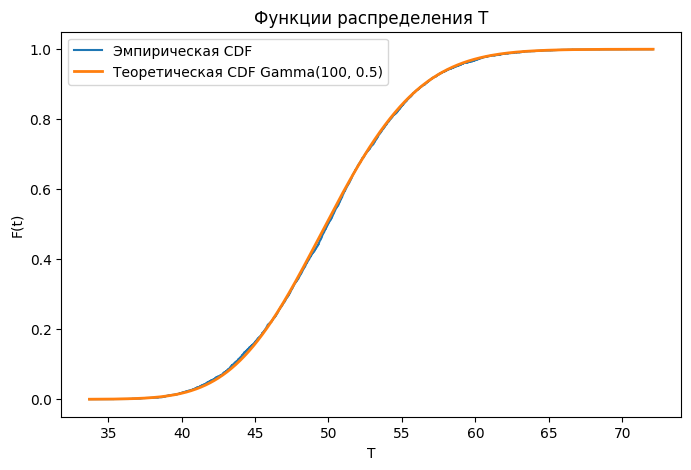

In [8]:
T_sorted = np.sort(T)
n = len(T_sorted)
F_emp = np.arange(1, n+1) / n
gamma_cdf = stats.gamma.cdf(T_sorted, a=N_blades, loc=0, scale=1/lam)

plt.figure(figsize=(8, 5))
plt.step(T_sorted, F_emp, where='post', label="Эмпирическая CDF")
plt.plot(T_sorted, gamma_cdf, label="Теоретическая CDF Gamma(100, 0.5)", linewidth=2)
plt.legend()
plt.title("Функции распределения T")
plt.xlabel("T")
plt.ylabel("F(t)")
plt.show()

### Критерий Колмогорова–Смирнова

In [9]:
ks_stat, ks_p = stats.kstest(T, 'gamma', args=(N_blades, 0, 1/lam))
print(f"\nКритерий К–С: статистика = {ks_stat:.5f}, p = {ks_p:.4f}")
if ks_p >= alpha:
    print("→ Принимаем H0: распределение T согласуется с Gamma(100, 0.5)")
else:
    print("→ Отвергаем H0")



Критерий К–С: статистика = 0.01643, p = 0.1329
→ Принимаем H0: распределение T согласуется с Gamma(100, 0.5)


### χ²-тест Пирсона

In [10]:
m = 10
bin_edges = np.linspace(T.min(), T.max(), m + 1)
n_j, _ = np.histogram(T, bins=bin_edges)
n = len(T)

F_edges = stats.gamma.cdf(bin_edges, a=k_hat, loc=0, scale=theta_hat)
p_j = np.diff(F_edges)
E_j = n * p_j

if E_j.min() < 5:
    print("Некоторые ожидаемые частоты < 5 — χ²-тест может быть неточен")

chi2_stat = np.sum((n_j - E_j)**2 / E_j)
df = m - 1 - 2  # m интервалов, 2 оценённых параметра
p_chi2 = 1 - stats.chi2.cdf(chi2_stat, df)

print(f"\nχ²-тест: χ² = {chi2_stat:.4f}, df = {df}, p = {p_chi2:.4f}")
if p_chi2 >= alpha:
    print("→ Принимаем H0: данные согласуются с гамма-распределением")
else:
    print("→ Отвергаем H0")

Некоторые ожидаемые частоты < 5 — χ²-тест может быть неточен

χ²-тест: χ² = 8.2013, df = 7, p = 0.3152
→ Принимаем H0: данные согласуются с гамма-распределением
